### Vorbereitungen

yum install texlive-collection-latexextra texlive-collection-mathscience python-pip pandoc

pip install --user notebook pandas seaborn scipy

In [1]:
import math
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress

In [2]:
sns.set_theme(context='paper', style="whitegrid", color_codes=True)

plt.rcParams["axes.titlesize"] = 13 # default: 9
plt.rcParams["axes.labelsize"] = 13 # default: 9
plt.rcParams["legend.fontsize"] = 11 # default: 8.8
plt.rcParams["legend.title_fontsize"] = 11 # default: 8.8
plt.rcParams["xtick.labelsize"] = 11 # default: 8.8
plt.rcParams["ytick.labelsize"] = 11 # default: 8.8

In [3]:
H_column = r'$H$ in $\frac{A}{m}$'
I_column = r'$I_\mathrm{max}$ in A'
M_column = r'M in $10^6\ \frac{A}{m}$'

In [4]:
def plot(data, hue_column=I_column, x_column=H_column, filename=None):
    img = sns.relplot(
        data=data,
        x=x_column,
        y=M_column,
        hue=hue_column,
        height=5,
        legend='full',
        
    )
    if filename is not None:
        img.figure.savefig(filename, bbox_inches='tight')

In [5]:
def subplot(data, x_column=H_column, y_column=M_column, axis=None):
    return sns.scatterplot(
        data=data,
        x=x_column,
        y=y_column,
        hue=I_column,
        marker='x',
        ax=axis        
    )

Make symmetrical due to removing / adding an offset

In [6]:
def remove_offset(series):
    diff = series.max() + series.min()
    offset = diff/2
    print(f'offset {series.name}: {round(offset, 2)}')
    return series - offset

Making symmetrical is optional: Not wanted for Temperature graph

In [7]:
def H(df, I_max, n_p, offset=True):
    calc = df.copy()
    if offset:
        calc['H'] = remove_offset(calc['H'])

    U_max = calc['H'].abs().max()
    r = 1.5/100 # m
    return calc['H'].apply(lambda U: n_p/(2 * math.pi * r) * (I_max/U_max) * U)

In [8]:
def H_heizbar(df, I_max, offset=True):
    return H(df, I_max, n_p=17, offset=offset)

In [9]:
def H_spalt(df, I_max, offset=True):
    return H(df, I_max, n_p=54, offset=offset)

In [10]:
def M(df, offset=True):
    calc = df.copy()
    if offset:
        calc['M'] = remove_offset(calc['M'])

    nu = 50 # Hz
    n_s = 17
    q = 0.9/10_000 # m^2
    mu_0 = 4* math.pi * 1e-7
    return calc['M'].apply(lambda U: U / (47*4*nu*n_s*q*mu_0) / 1e6)

## 3.3.1

#### Overview

In [11]:
heizbar_a = pd.read_csv("3.3.1.a.csv", sep='\t')
heizbar_b = pd.read_csv("3.3.1.b.csv", sep='\t')
heizbar_c = pd.read_csv("3.3.1.c.csv", sep='\t')
heizbar_d = pd.read_csv("3.3.1.d.csv", sep='\t')

In [12]:
heizbar_a[I_column] = r'3.00 $\pm$ 0.01'
heizbar_a['Ringkern'] = 'ohne Spalt'
heizbar_b[I_column] = r'1.00 $\pm$ 0.01'
heizbar_c[I_column] = r'0.29 $\pm$ 0.01'
heizbar_d[I_column] = r'0.10 $\pm$ 0.01'

In [13]:
heizbar_a[H_column] = H_heizbar(heizbar_a, I_max=3)
heizbar_b[H_column] = H_heizbar(heizbar_b, I_max=1)
heizbar_c[H_column] = H_heizbar(heizbar_c, I_max=0.29)
heizbar_d[H_column] = H_heizbar(heizbar_d, I_max=0.1)

heizbar_a[M_column] = M(heizbar_a)
heizbar_b[M_column] = M(heizbar_b)
heizbar_c[M_column] = M(heizbar_c)
heizbar_d[M_column] = M(heizbar_d)

offset H: 0.03
offset H: 0.02
offset H: 0.03
offset H: 0.03
offset M: 0.08
offset M: 0.09
offset M: 0.11
offset M: 0.12


Alle Messungen in verschiedenen Plots

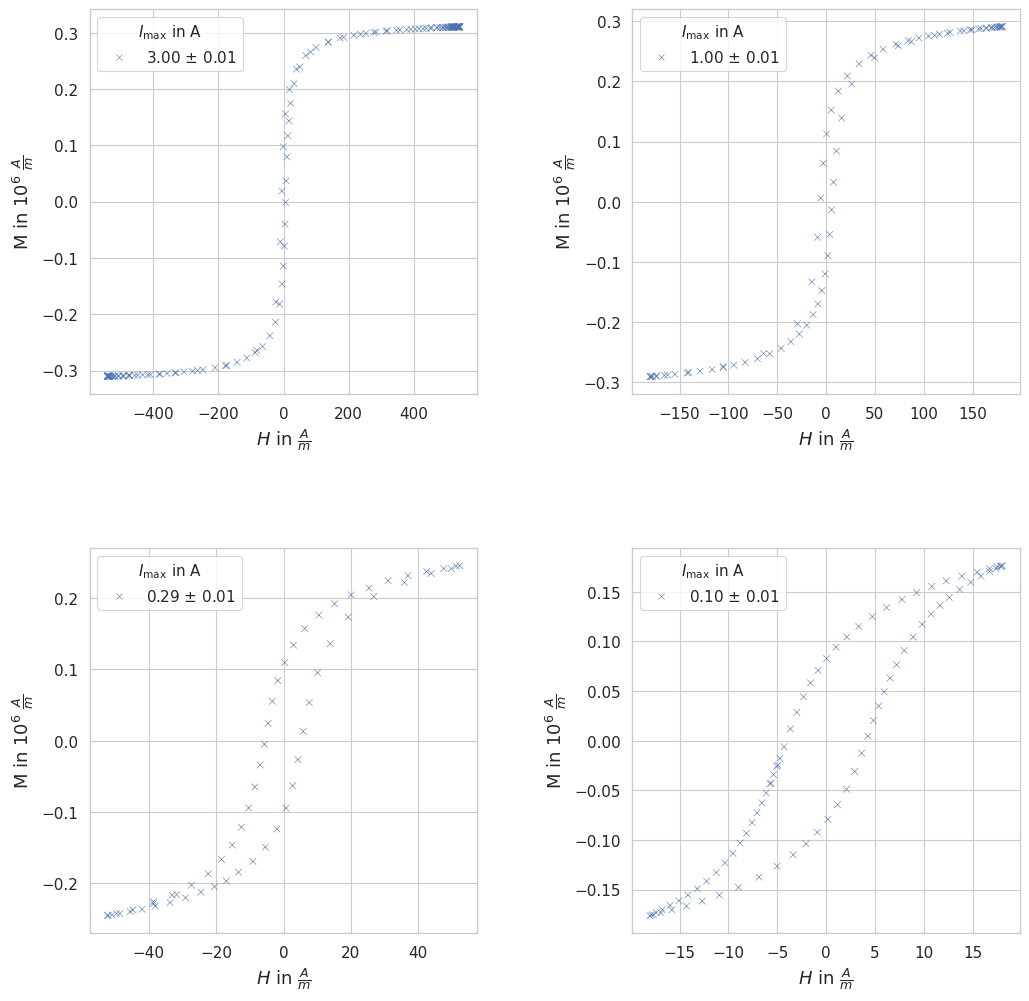

In [14]:
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# 4 subplots jeweils 1/2 Breite
# https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.add_subplot
ax = fig.add_subplot(2, 2, 1)
subplot(heizbar_a, axis=ax)

ax = fig.add_subplot(2, 2, 2)
subplot(heizbar_b, axis=ax)

ax = fig.add_subplot(2, 2, 3)
subplot(heizbar_c, axis=ax)

ax = fig.add_subplot(2, 2, 4)
subplot(heizbar_d, axis=ax)

fig.savefig('../../media/B2.4/3.3.1_single_measures.svg', bbox_inches='tight')

plt.show()

#### details & values

##### ermittle $H_K$
`threshold` muss so gewählt werden, dass maximal 4 Werte herausgefiltert werden. Ideal wären zwei, falls ein Wert oben und ein Wert unten ist.

In [15]:
df = heizbar_b
threshold = 0.03

df[df[M_column].abs() < threshold][[M_column, H_column]]

,M in $10^6\ \frac{A}{m}$,$H$ in $\frac{A}{m}$
31,0.006050,-5.495494
65,-0.013589,5.608280


In [16]:
m = df[df[M_column].abs() < threshold][H_column].abs().mean()
d = df[df[M_column].abs() < threshold][H_column].abs().std()
print(m.round(2), r'&\pm', d.round(2), '&')

5.55 &\pm 0.08 &


##### ermittle Remanenz
`threshold` muss so gewählt werden, dass maximal 3 Werte herausgefiltert werden. Ideal wären zwei, falls ein Wert oben und ein Wert unten ist.

Der Fehler muss mindestens das halbe Offset sein.

In [17]:
df = heizbar_a
threshold = 2

df[df[H_column].abs() < threshold][M_column]

41    -0.114156
124    0.097601
Name: M in $10^6\ \frac{A}{m}$, dtype: float64

In [18]:
m = df[df[H_column].abs() < threshold][M_column].abs().mean()
d = df[df[H_column].abs() < threshold][M_column].abs().std()
print(m.round(3), r'&\pm', d.round(3), '&')

0.106 &\pm 0.012 &


##### $M_\mathrm{max}$
Der Fehler ist das Offset

In [19]:
df = heizbar_d
m = (df[M_column].max() + abs(df[M_column].min()))/2
print(m.round(2), r'&\pm', d.round(2))

0.18 &\pm 0.01


## 3.3.2

In [20]:
komm_a = pd.read_csv('3.3.2.a.csv', sep='\t')
komm_b = pd.read_csv('3.3.2.b.csv', sep='\t')

In [21]:
komm_a[H_column] = H_heizbar(komm_a, I_max=3, offset=False)
komm_b[H_column] = H_heizbar(komm_b, I_max=0.08, offset=False)

komm_a[M_column] = M(komm_a, offset=False)
komm_b[M_column] = M(komm_b, offset=False)

In [22]:
komm_a[I_column] = r'3.00 $\pm$ 0.01'
komm_b[I_column] = r'0.10 $\pm$ 0.01'

In [23]:
komm_b = komm_b[komm_b[H_column] <= 0]
# komm_b[H_column] *= -1
# komm_b[M_column] *= -1

In [24]:
komm_a = komm_a.sort_values(by=H_column)
komm_b = komm_b.sort_values(by=H_column)

In [25]:
x_range_a = np.linspace(komm_a[H_column].min(), komm_a[H_column].max(), 100)
interp_a = np.interp(x_range_a, komm_a[H_column], komm_a[M_column])

In [26]:
x_range_b = np.linspace(komm_b[H_column].min(), komm_b[H_column].max(), 100)
interp_b = np.interp(x_range_b, komm_b[H_column], komm_b[M_column])

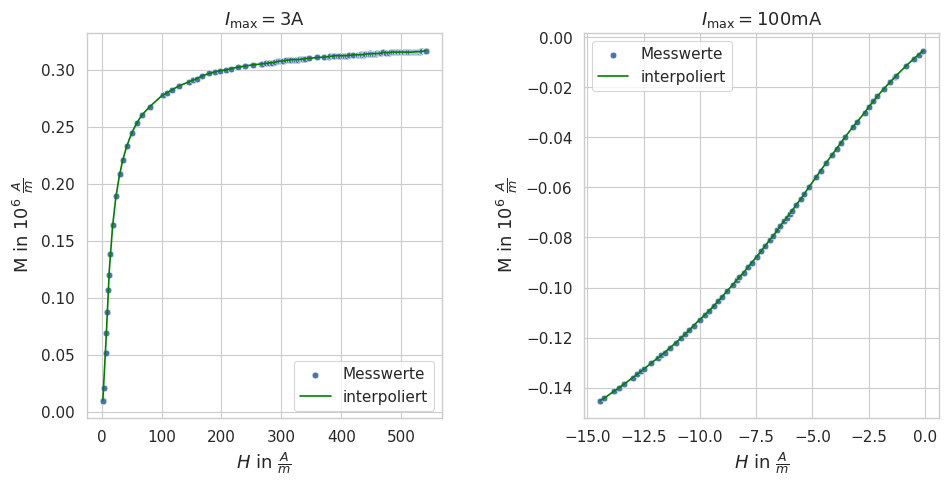

In [27]:
fig = plt.figure(figsize=(11,5))
fig.subplots_adjust(wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
plt.title(r'$I_\mathrm{max} = 3$A')
sns.scatterplot(
    data=komm_a,
    x=H_column,
    y=M_column,
    ax=ax,
    label='Messwerte'
)
plt.plot(x_range_a, interp_a, color='green', label='interpoliert')
plt.legend()

ax = fig.add_subplot(1, 2, 2)
plt.title(r'$I_\mathrm{max} = 100$mA')
sns.scatterplot(
    data=komm_b,
    x=H_column,
    y=M_column,
    ax=ax,
    label='Messwerte'
)
plt.plot(x_range_b, interp_b, color='green', label='interpoliert')
plt.legend()

fig.savefig('../../media/B2.4/3.3.2_Messung.svg', bbox_inches='tight')

##### Ableitung

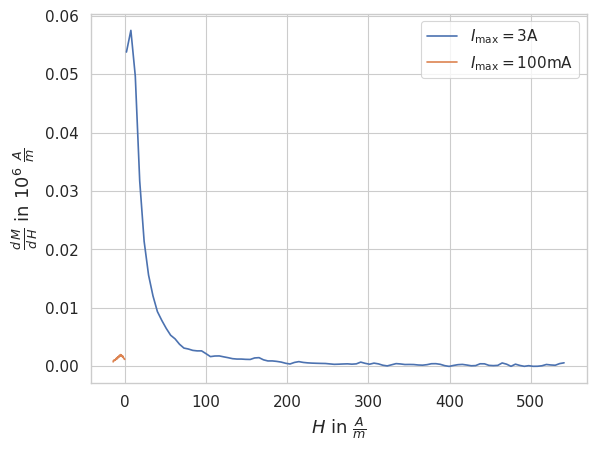

In [28]:
_, y_a = np.gradient([x_range_a, interp_a])
_, y_b = np.gradient([x_range_b, interp_b])

fig = plt.figure()

plt.plot(x_range_a, y_a[1], label=r'$I_\mathrm{max} = 3$A')
plt.plot(x_range_b, y_b[1], label=r'$I_\mathrm{max} = 100$mA')

plt.xlabel(H_column)
plt.ylabel(r'$\frac{d\,M}{d\,H}$ in $10^6\ \frac{A}{m}$')

plt.legend()

fig.savefig('../../media/B2.4/3.3.2_Ableitung.svg', bbox_inches='tight')

## 3.3.3

In [29]:
data = pd.read_csv('3.3.3.csv', sep='\t')
data[I_column] = r'3.00 $\pm$ 0.01'
T_column = r'T in $^\circ$C'
data[T_column] = data['T']
data[M_column] = M(data)

offset M: 2.84


In [30]:
data

,T,M,$I_\mathrm{max}$ in A,T in $^\circ$C,M in $10^6\ \frac{A}{m}$
0,21.313081,5.581297,3.00 $\pm$ 0.01,21.313081,0.151625
1,21.338784,5.580288,3.00 $\pm$ 0.01,21.338784,0.151569
2,21.360401,5.579671,3.00 $\pm$ 0.01,21.360401,0.151535
3,21.380637,5.578410,3.00 $\pm$ 0.01,21.380637,0.151465
4,21.398098,5.578146,3.00 $\pm$ 0.01,21.398098,0.151450
...,...,...,...,...,...
1790,80.715002,0.103282,3.00 $\pm$ 0.01,80.715002,-0.151481
1791,80.791621,0.104625,3.00 $\pm$ 0.01,80.791621,-0.151407
1792,80.869741,0.102399,3.00 $\pm$ 0.01,80.869741,-0.151530
1793,80.946711,0.101524,3.00 $\pm$ 0.01,80.946711,-0.151578


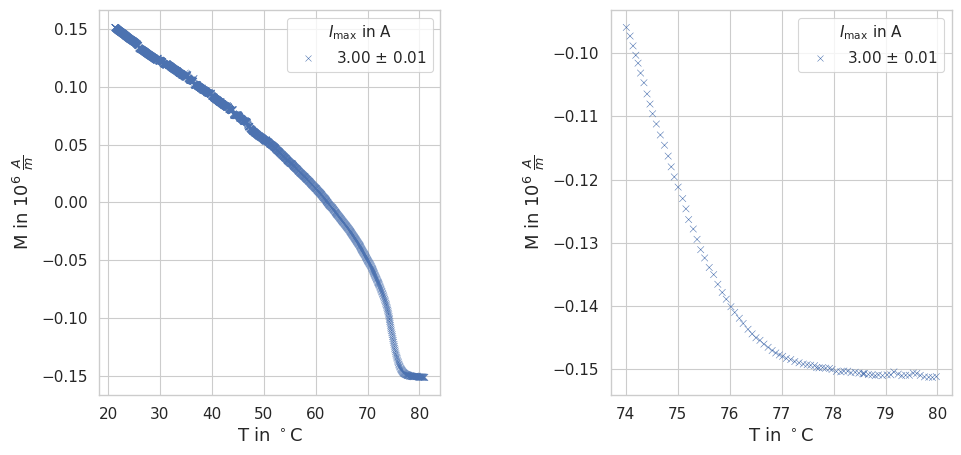

In [31]:
fig = plt.figure(figsize=(11,5))
fig.subplots_adjust(wspace=0.5)

ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(
    data=data,
    x=T_column,
    y=M_column,
    hue=I_column,
    marker='x',
    legend='full',
    ax=ax
)

ax = fig.add_subplot(1, 2, 2)
sns.scatterplot(
    data=data[(data[T_column] > 74)&(data[T_column] < 80)],
    x=T_column,
    y=M_column,
    hue=I_column,
    marker='x',
    legend='full',
    ax=ax
)

fig.savefig('../../media/B2.4/3.3.3.svg', bbox_inches='tight')

## 3.3.4

Messungsdetails:
* 3.4.1: 0.94A
* 3.4.2: 3.0A, 1mm
* 3.4.3: 2.12A, 0.5mm
* 3.4.4: 1.27A, 0.2mm
* 3.4.5: 1.0A, 0.125mm
* 3.4.6: 0.79A, 0.075mm
* 3.4.7: 0.50A, 0.0mm

In [32]:
spalt_a = pd.read_csv('3.4.1.csv', sep='\t')
spalt_b = pd.read_csv('3.4.2.csv', sep='\t')
spalt_c = pd.read_csv('3.4.3.csv', sep='\t')
spalt_d = pd.read_csv('3.4.4.csv', sep='\t')
spalt_e = pd.read_csv('3.4.5.csv', sep='\t')
spalt_f = pd.read_csv('3.4.6.csv', sep='\t')
spalt_g = pd.read_csv('3.4.7.csv', sep='\t')

In [33]:
spalt_a[H_column] = H_spalt(spalt_a, I_max=0.94)
spalt_b[H_column] = H_spalt(spalt_b, I_max=3.0)
spalt_c[H_column] = H_spalt(spalt_c, I_max=2.12)
spalt_d[H_column] = H_spalt(spalt_d, I_max=1.27)
spalt_e[H_column] = H_spalt(spalt_e, I_max=1.0)
spalt_f[H_column] = H_spalt(spalt_f, I_max=0.79)
spalt_g[H_column] = H_spalt(spalt_g, I_max=0.5)

spalt_a[M_column] = M(spalt_a)
spalt_b[M_column] = M(spalt_b)
spalt_c[M_column] = M(spalt_c)
spalt_d[M_column] = M(spalt_d)
spalt_e[M_column] = M(spalt_e)
spalt_f[M_column] = M(spalt_f)
spalt_g[M_column] = M(spalt_g)

offset H: 0.03
offset H: 0.01
offset H: 0.02
offset H: 0.02
offset H: 0.03
offset H: 0.03
offset H: 0.03
offset M: 0.07
offset M: 0.06
offset M: 0.07
offset M: 0.07
offset M: 0.07
offset M: 0.08
offset M: 0.08


In [34]:
spalt_a['Ringkern'] = 'mit Spalt'

S_column = 'Spaltbreite'
spalt_a[S_column] = 'I_max=0.94A'
spalt_b[S_column] = r'2.00 mm'
spalt_c[S_column] = r'1.00 mm'
spalt_d[S_column] = r'0.40 mm'
spalt_e[S_column] = r'0.25 mm'
spalt_f[S_column] = r'0.15 mm'
spalt_g[S_column] = r'0.00 mm'

#### Vergleich

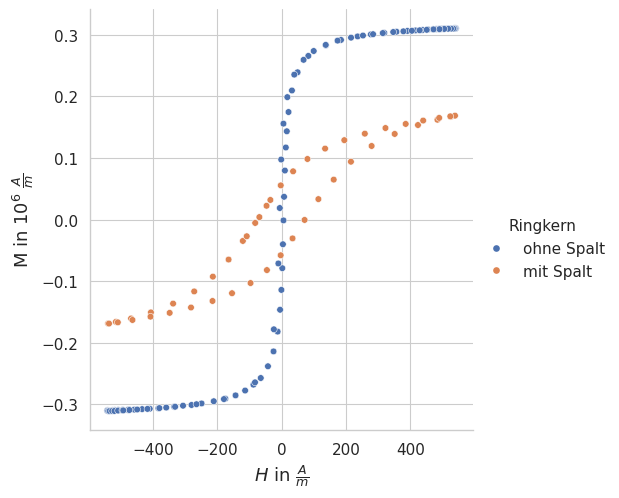

In [35]:
plot(pd.concat([heizbar_a, spalt_a]), hue_column='Ringkern', filename='../../media/B2.4/3.3.3_comparison.svg')

##### ermittle $H_K$
`threshold` muss so gewählt werden, dass maximal 4 Werte herausgefiltert werden. Ideal wären zwei, falls ein Wert oben und ein Wert unten ist.

In [36]:
df = spalt_a
threshold = 0.02

df[df[M_column].abs() < threshold][[M_column, H_column]]

,M in $10^6\ \frac{A}{m}$,$H$ in $\frac{A}{m}$
1,-0.005407,-81.824034
23,-0.000530,71.580132
45,0.004108,-68.855246


In [37]:
m = df[df[M_column].abs() < threshold][H_column].abs().mean()
d = df[df[M_column].abs() < threshold][H_column].abs().std()
print(m.round(2), r'\pm', d.round(2))

74.09 \pm 6.84


##### ermittle Remanenz
`threshold` muss so gewählt werden, dass maximal 3 Werte herausgefiltert werden. Ideal wären zwei, falls ein Wert oben und ein Wert unten ist.

Der Fehler muss mindestens das halbe Offset sein.

In [38]:
df = spalt_a
threshold = 3

df[df[H_column].abs() < threshold][M_column]

21   -0.057914
43    0.055622
Name: M in $10^6\ \frac{A}{m}$, dtype: float64

In [39]:
m = df[df[H_column].abs() < threshold][M_column].abs().mean()
d = df[df[H_column].abs() < threshold][M_column].abs().std()
print(m.round(3), r'&\pm', d.round(3))

0.057 &\pm 0.002


##### $M_\mathrm{max}$
Der Fehler ist das Offset.

In [40]:
df = spalt_a
m = (df[M_column].max() + abs(df[M_column].min()))/2
d = (df[M_column].max() - abs(df[M_column].min()))/2
print(m.round(3), r'&\pm', d.round(3))

0.169 &\pm 0.0


#### Entmagnetisierungsfaktor

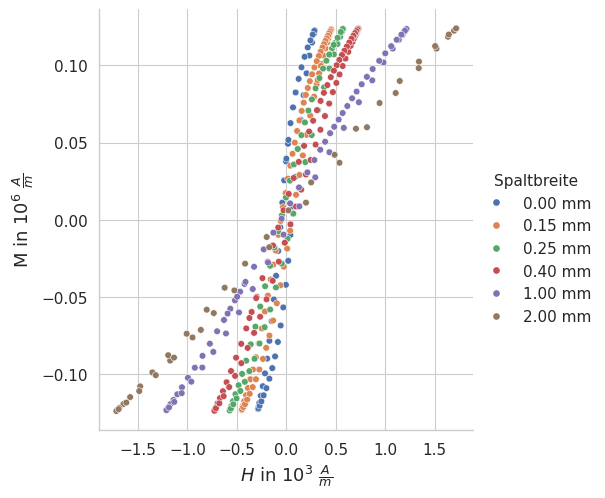

In [41]:
H_column_rough = r'$H$ in $10^3\ \frac{A}{m}$'
spalt_all = pd.concat([spalt_g,spalt_f,spalt_e,spalt_d,spalt_c,spalt_b])
spalt_all[H_column_rough] = spalt_all[H_column] / 1000

plot(spalt_all, x_column=H_column_rough, hue_column=S_column, filename='../../media/B2.4/3.3.3_overview.svg')

#### Entmagnetisierungsfelder
Der Fehler ist das halbe Offset

In [42]:
# offset b H: 0.01
# offset c H: 0.02
# offset d H: 0.02
# offset e H: 0.03
# offset f H: 0.03
# offset g H: 0.03

$H_\mathrm{ent}$

In [43]:
df = spalt_b

avg = (df[H_column].max() - spalt_g[H_column].max() - (df[H_column].min() - spalt_g[H_column].min()))/2e3
err = abs((df[H_column].max() - spalt_g[H_column].max() + (df[H_column].min() - spalt_g[H_column].min()))/2e3)
print(df['Spaltbreite'][0])
print(avg.round(2), r'&\pm', err.round(2), '&')

2.00 mm
1.43 &\pm 0.0 &


##### $M_\mathrm{max}$
Der Fehler ist der Offset

In [44]:
# offset b M: 0.06
# offset c M: 0.07
# offset d M: 0.07
# offset e M: 0.07
# offset f M: 0.08
# offset g M: 0.08

In [45]:
df = spalt_g
m = (df[M_column].max() + abs(df[M_column].min()))/2
d = (df[M_column].max() - abs(df[M_column].min()))/2
print(df['Spaltbreite'][0])
print(m.round(2), r'\pm', d.round(2))

0.00 mm
0.12 \pm 0.0


##### N experimentell
Die zurückgegebenen Werte werden in $10^{-3}$ angegeben.

In [46]:
def N(delta_H):
    delta_H = delta_H * 1e3
    M_max = 0.12 * 1e6

    avg = delta_H / M_max
    return round(avg*1e3, 2)

In [47]:
def N_err(delta_H, delta_H_err):
    # fix magnitude
    h = delta_H * 1e3
    err_h = delta_H_err * 1e3

    # constants
    M_max = 0.12 * 1e6
    err_M = 0.08 * 1e6

    err_squared = (err_h/M_max)**2 + (h*err_M/(M_max**2))**2
    return round(math.sqrt(err_squared)*1e3, 2)

In [48]:
def N_theo(l_L):
    R = 15 # mm
    return round(l_L / (2*math.pi*R + l_L) * 1e3, 3)

In [49]:
spaltbreiten = [0, 0.15, 0.25, 0.4, 1, 2]
delta_H = [
    (0,0.3), # 0 mm
    (0.17, 0.03), # 0.15 mm
    (0.29, 0.03), # 0.25 mm
    (0.44, 0.02), # 0.4 mm
    (0.93, 0.02), # 1 mm
    (1.43, 0.01) # 2mm
]

N_exp_result = [ N(h) for h, err in delta_H ]
N_exp_err = [ N_err(h, err) for h, err in delta_H ]
N_theo_result = [ N_theo(d) for d in spaltbreiten ]

In [50]:
df = pd.DataFrame(
    {
        '$l_L$ in [mm]': spaltbreiten,
        '$N$': N_exp_result,
        r'$\Delta N$': N_exp_err,
        r'$N_\mathrm{theo}$': N_theo_result
    }
)
df

,$l_L$ in [mm],$N$,$\Delta N$,$N_\mathrm{theo}$
0,0.00,0.00,2.50,0.000
1,0.15,1.42,0.98,1.589
2,0.25,2.42,1.63,2.646
3,0.40,3.67,2.45,4.226
4,1.00,7.75,5.17,10.499
5,2.00,11.92,7.94,20.780


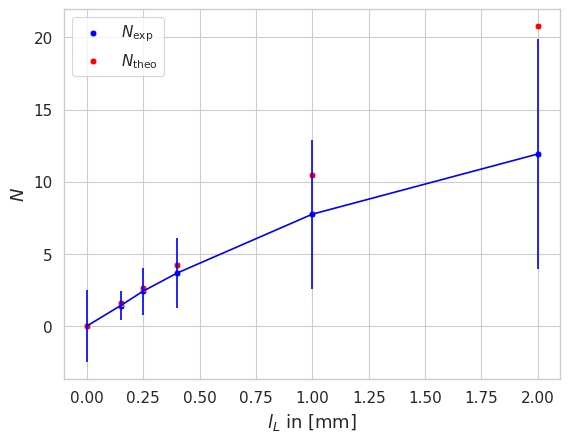

In [51]:
ax = sns.scatterplot(df, x='$l_L$ in [mm]', y='$N$', label=r'$N_\mathrm{exp}$', color='blue')
sns.scatterplot(df, x='$l_L$ in [mm]', y=r'$N_\mathrm{theo}$', label=r'$N_\mathrm{theo}$', color='red', ax=ax)
sns.mpl.pyplot.errorbar(x=df['$l_L$ in [mm]'], y=df['$N$'], yerr=df[r'$\Delta N$'], color='blue')

ax.figure.savefig('../../media/B2.4/3.3.4_N.svg', bbox_inches='tight')